# Group information

Names:
Guilherme Webster Chamoun
Vinicius Forato Coracin


RAs:
257111
231528

## Objective:

To explore **deep learning** techniques, focused on **Convolutional Neural Networks**. In this task you'll be architecturing different CNNs to solve an image classification problem.

This **MUST** be developed using the pytorch and Sklearn libraries (PyTorch Lightning is **not** allowed).

*Tip: Use the Pillow (PIL) library to work with images with pytorch. Also, you can use [tqdm](https://github.com/tqdm/tqdm) library to see the progress of the training process.*

## Dataset

The dataset you should use is an adaptation of the "CIFAR10" dataset. The CIFAR10 dataset is a dataset of 32x32 images of 10 different classes, and is extensivelly used for classification of images using CNN.

In this work, You will only will select 3 classes [from CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). You also will only use a limited amount of the data of each class (the original dataset has 6000 images per class). For each class, the select 400 for training, 200 for validation and 300 for test. This is defined so that the training steps are faster, but it makes the problem harder, as we are working with few data points.

As in every machine learning task, we need to understand and analyze the data. From the way that the dataset was collected (data collection protocol, equipment used, people involved), to its final result (resulting files) and objective. When dealing with images, we usually want to track possible biases that different classes may have when collected. This dataset contains images of the target objects in a centered position in the foreground, having few biases related to the common background of some classes (for example: airplanes in the blue sky).

As in the other tasks we already covered the data analysis part, we will focus on the technical machine learning parts for this one. Just remember that images are another type of data and we also could (and **should**) analyze the information before applying machine learning techniques blindly.

## Load the dataset (2 Points)

When working with Pytorch, we need to create a "Dataset" class that usually will handle the data loading, as well as the data transformations, and will allow us to retrieve the data with the respective label.

Data transformations are an important part of Pytorch datasets, as we already studied in the lectures that data augmentation can be powerful in training deep neural networks. But some of those transformations are just to define the entry of the model as Pytorch tensors or normalizing data, which can be impactful as well.

Create a Pytorch Dataset and Dataloader with and without data augmentation for training data (to compare later). The `Dataset` class has 3 required methods: `__init__`, `__len__`, and `__getitem__`. In the code below we have some basic idea of an ImageDataset.

You can choose how to implement the image loading in the class:
- Inside the `__getitem__` method (low memory usage for each dataset instance, slower for training)
- Inside the `__init__` method (saves all images on memory, but training is faster)

Either implementation is ok, if the machine you're using supports the loading of all images this is probably better for performance.

For a deeper look at Pytorch datasets and dataloaders, look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

The images are already divided by folder for train, validation and test, and you should follow this order. The targets of each image are described in the filename in the following pattern: `[image_number]_[class].jpg`.

To create the data augmentation you can follow the `preparation` example below, and add different Pytorch transformations. A list of available transformations (as well as examples) can be found in the [official documentation (here)](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

In [ ]:
import torch
from torch import nn as nn
import torchvision.transforms.v2 as transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Unpickle function to load the CIFAR-10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load CIFAR-10 data
def load_cifar10_data(data_path, classes_to_include, split_sizes=(400, 200, 300)):
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    for i in range(1,6): # 5 training batches
      data_batch = unpickle(os.path.join(data_path, f'data_batch_{i}'))
      data = data_batch[b'data']
      labels = data_batch[b'labels']

      # reshape and separate each image into rbg channels
      data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)

      for img, label in zip(data, labels):
        if label in classes_to_include:
          idx = classes_to_include.index(label)
          if len(train_data) < split_sizes[0]:
            train_data.append(img)
            train_labels.append(idx)
          elif len(val_data) < split_sizes[1]:
            val_data.append(img)
            val_labels.append(idx)

    # Load test_batch
    test_batch = unpickle(os.path.join(data_path, "test_batch"))
    test_data_raw = test_batch[b'data']
    test_labels_raw = test_batch[b'labels']
    test_data_raw = test_data_raw.reshape(len(test_data_raw), 3, 32, 32).transpose(0, 2, 3, 1)

    # Filter and add test batch data
    for img, label in zip(test_data_raw, test_labels_raw):
        if label in classes_to_include and len(test_data) < split_sizes[2]:
            class_idx = classes_to_include.index(label)
            test_data.append(img)
            test_labels.append(class_idx)

    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [ ]:
# Set the expected input shape
# input_width =  # define your CNN input width and height
# input_height =
# nchannels = 3

# train transformations - here we can have data augmentation, as well as the transformations needed for preparing the data for the model
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# test transformations - here we should only have the transformations needed for preparing the data for the model
# This is just an example, but you can you can use it.
preparation = transforms.Compose([
              # make all images the same size with a specific interpolation method
              #transforms.Resize((input_width,input_height), interpolation=transforms.InterpolationMode.BILINEAR,
              #                  max_size=None, antialias=True),
              # transform the image to Tensor (this will change the configuration from Height x Width x Channels to Channels x Height x Width)
              transforms.ToTensor(),
              # this normalization is just an example, based on the ImageNet mean and standard deviation of images. You can test without it if you want!
              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])

class ImageDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    '''
    Return a tuple with the image (as a Tensor) and the respective target at position idx.
    '''
    image = self.images[idx]
    label = self.labels[idx]
    image = Image.fromarray(image)

    if self.transform:
      image = self.transform(image)

    return image, label

# Loading the CIFAR-10 data
data_path = '/content/drive/MyDrive/cifar-10-batches-py'
classes_to_include = [0, 1, 9] # airplane, automobile and truck
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_cifar10_data(
    data_path, classes_to_include)

# Creating the datasets with the transformations
train_aug_dataset = ImageDataset(train_images, train_labels, transform=augmentation)
train_dataset = ImageDataset(train_images, train_labels, transform=preparation)
val_dataset = ImageDataset(val_images, val_labels, transform=preparation)
test_dataset = ImageDataset(test_images, test_labels, transform=preparation)

Mounted at /content/drive


In [ ]:

from torch.utils.data import DataLoader

# Batch size
batch_size = 64

# Create the loaders
# Create DataLoaders
train_aug_loader = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Image dimensions: 32x32x3
Class of the image (target):  2


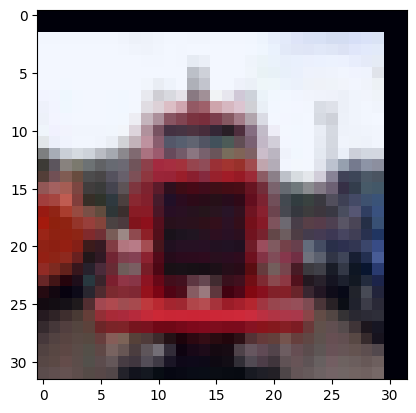

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize images from the training set
datatensor = train_aug_dataset  # Use the augmented dataset

# Visualizing the 100th image from the augmented training set
image, target = datatensor[100]  # This will call the '__getitem__' method
nchannels = image.shape[0]
height = image.shape[1]
width = image.shape[2]

# Convert the Tensor back to image shape (Height x Width x Channels)
image = image.permute(1, 2, 0).numpy()

# Rescale the image to [0, 255] to display it properly
image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
image = image.astype('uint8')

# Print image details
print("Image dimensions: {}x{}x{}".format(width, height, nchannels))
plt.imshow(image)

# Display the class label of the image
print("Class of the image (target): ", target)

# Show the image
plt.show()


## Train a baseline model (1 Point)

Before going for the deep learning approach, you should test a baseline model in this problem. To do so, train a RandomForectClassifier, where the inputs are the flattened images (all pixes of 3 channels concatenated).

You should use the same train/validation/test division that you'll be using in the next section. You can use the Sklearn library for this task. Remember to test and plot a confusion matrix with the results.

Validation Accuracy: 0.6750
Test Accuracy: 0.6233


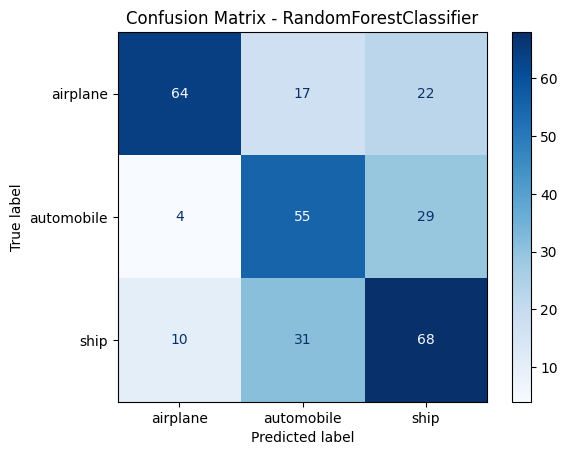

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to flatten images
def flatten_images(images):
    return np.array([img.flatten() for img in images])

# Prepare the datasets: flattening the images
X_train = flatten_images(train_images)
X_val = flatten_images(val_images)
X_test = flatten_images(test_images)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# Train the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Validate the model on the validation set
val_accuracy = rf_clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Test the model on the test set
y_pred = rf_clf.predict(X_test)
test_accuracy = rf_clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['airplane', 'automobile', 'ship'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()


## Build a CNN (6 Points)

In this section, you should construct and validate a CNN architecture for the given problem.

It's required that you test at least the following parts of a CNN:
- Number of convolutional layers and different output sizes
- Kernel size of filters
- Number of training epochs
- Learning rate of the network
- Batchsize used in dataloader
- Stride on convolutional or pooling layers
- Different architecture for the final dense layer (with or without hidden layers and their size)

Also, you must compare at least for one network if the data augmentation is helping the training process or not.

Lastly, you must change the `Criterion` function to return the balanced accuracy instead of the normal one.

--------

The process to build a CNN is an exploratory analysis and should be done carefully. As this is a costly process, you will not test all possibilities between each other, you should interpret the results at each step and understand what is happening or not happening.

As this is a costly process, you should use the normal division of train/validation/test, instead of cross validation. Also, at each network built and trained/validated, you should look at the results to understand if any overfitting or underfitting is happening. Save the values of each batch of train and validation to analyze how the model performed over the epochs.

### Exploding/vanishing gradients

As we already learned, the weights of a neural network are updated using the backpropagation algorithm. As our network grows in depth, there are two problems that can occur with the backpropagation algorithm, known as Exploding and Vanishing gradients.

As both names imply, both conditions relate to a gradient calculation that goes out of control for some reason.

The exploding gradient can happen when the current weights generate a very large loss, and all the network weights are updated by a huge amount. This can lead to a cycle where the network is not able to learn because every learning step impacts too much the network, making it very unstable.

On the other side, the vanishing gradient will happen when the gradients get too small, and the updates are not able to propagate to the initial layers.

There are a couple of ways to solve those issues. The first is to use an activation function that is "non-saturating". The sigmoid function is an example of a saturating function because its derivative tends to 0 on larger positive or negative values. The best activation functions to avoid this issue are the ReLU and its variations (LReLU, PReLU, ELU, etc). All those examples help to mitigate the vanishing gradient.

Another important step is to initialize the weights of the network properly. Initializing the weights randomly can also lead to vanishing/exploding gradients in some situations. The common strategy is to use a heuristic. We are not going to cover this manner in a deeper aspect, but the Xavier initialization is already implemented in the example below.

Finally, the best thing to avoid vanishing and exploding gradients in a deep CNN is to use the Batch Normalization technique. This technique is a new operation on the CNN, that normalizes its input and adds a parameter for scale and another for shifting. This enables the network to learn the optimal scale and mean of the layer. This normalization uses the data of the batch of images being executed on the model to find the mean and standard deviation. In pytorch, there is a function to use this technique in the `nn` module: `nn.BatchNorm2d()`. The BatchNorm operation can be used before or after the activation function.

For example:
- Conv -> BatchNorm -> Activation(ReLU) -> Pooling
Or
- Conv -> Activation(ReLU) -> BatchNorm -> Pooling).

In this task, you may face problems concerning the stability and convergence of the network because of the exploding or vanishing gradients, and it is recommended that you use the techniques cited to avoid this issue.

In [ ]:
gpu = torch.cuda.is_available()

if not gpu:
  print("GPU not available!")

device = torch.device(0) if gpu else torch.device('cpu')

**Saving models**

As the CNN training process can take some time, is interesting to save your models, to avoid re-training in the case of a crash or just to save your work for other time.

The next cell shows a simple code to save and load pytorch models. Remember to keep the class of the model in the same way, as the state_dict will not work if you change the architecture. Create new classes for different tests, with names that correctly describe what is being tested.

**Note**: If you're using google colab, just saving the model is not enough. You need to save it for a folder in your google Drive, or download the files after saving them.

In [ ]:
# ===== How to save a pytorch model =====

## Since you have the class of the model, you can save the weights
## IMPORTANT: If you change the class implementation you will NOT be able to load the model again.
torch.save(model.to('cpu').state_dict(), "/path/to/save")

# ===== How to load a pytorch model =====

## Instantiate the model class as usual
model = Model(input_shape, nclasses)

## Load the state dict saved before
state_dict  = torch.load("/path/to/save")

## Load the weights in the model
model.load_state_dict(state_dict)

## Send the model to the GPU
model = model.to(device)

**Example of train/validate code**

In the next cells, we show an example of how to develop the train/validation functions using pytorch. You don't need to use this code, but it is a place to start.

In [ ]:

def train_batch(model, data, optimizer, criterion, device):
  '''
  Funtion that trains a batch of data in the 'device' (that should be a GPU)
  'data' is a batch of the dataloader.
  'optmizer' should be an instance of an pytorch optmizer. You don't need to test different optmizers, just go with SGD (torch.optim.SGD).
  'criterion' is a custom function to calculate the loss and accuracy of the predictions of the batch.
  'device' is the device that the model is loaded on.
  '''
  model.train()
  ims, targets = data
  ims = ims.to(device=device)
  targets = targets.to(device=device)
  preds = model(ims)
  loss, acc = criterion(model, preds, targets, device)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  return loss.item(), acc

def new_train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims = ims.to(device)
    targets = targets.to(device)
    preds = model(ims)

    loss, balanced_acc = criterion(model, preds, targets, device)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), balanced_acc

# This line avoid that the model weights change during validation
@torch.no_grad()
def validate_batch(model, data, criterion, device):
  '''
  Funtion that validates a batch of data in the 'device' (that should be a GPU).
  Same parameters as 'train_batch', but this time no optmizer is needed.
  '''
  model.eval()
  ims, targets = data
  ims = ims.to(device=device)
  targets = targets.to(device=device)
  preds = model(ims)
  loss, acc = criterion(model, preds, targets, device)

  return loss.item(), acc

@torch.no_grad()
def new_validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.to(device)
    targets = targets.to(device)
    preds = model(ims)

    loss, balanced_acc = criterion(model, preds, targets, device)

    return loss.item(), balanced_acc

def Criterion(model, preds, targets, device):
  '''
  Function that calculates the loss and accuracy of a batch predicted by the model.
  '''
  ce            = nn.CrossEntropyLoss().to(device) # You don't need to change the loss function (but you can if it makes sense on your analysis)
  loss          = ce(preds, targets.long())
  pred_labels   = torch.max(preds.data, 1)[1] # same as argmax
  acc           = torch.sum(pred_labels == targets.data)
  n             = pred_labels.size(0)
  acc           = acc/n

  return loss, acc

from sklearn.metrics import balanced_accuracy_score

def NewCriterion(model, preds, targets, device):
    """
    Function that calculates the loss and balanced accuracy of a batch predicted by the model.
    """
    ce = nn.CrossEntropyLoss().to(device)  # Use CrossEntropyLoss as the criterion
    loss = ce(preds, targets.long())  # Calculate the loss

    # Get the predicted labels
    pred_labels = torch.max(preds.data, 1)[1]

    # Move the predictions and targets to the CPU for balanced accuracy calculation
    pred_labels_np = pred_labels.cpu().numpy()
    targets_np = targets.cpu().numpy()

    # Calculate balanced accuracy using sklearn's balanced_accuracy_score
    balanced_acc = balanced_accuracy_score(targets_np, pred_labels_np)

    return loss, balanced_acc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 4x4 comes from the down-sampling
        self.fc2 = nn.Linear(512, n_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
      '''
      Initialize the network weights using the Xavier initialization.
      '''
      for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# Instantiate the CNN
input_shape = (3, 32, 32)  # CIFAR-10 images have 3 channels and are 32x32 pixels
n_classes = 3  # Since we're using airplane, automobile, and truck
# model = SimpleCNN(input_shape, n_classes)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = 0.0, 0.0
        val_loss, val_acc = 0.0, 0.0

        # Training loop
        for data in train_loader:
            loss, acc = train_batch(model, data, optimizer, criterion, device)
            train_loss += loss
            train_acc += acc

        # Validation loop
        for data in val_loader:
            loss, acc = validate_batch(model, data, criterion, device)
            val_loss += loss
            val_acc += acc

        # Average the losses and accuracies for each epoch
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Store losses and accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

def new_train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
    for epoch in range(n_epochs):
        train_loss, train_bal_acc = 0.0, 0.0
        val_loss, val_bal_acc = 0.0, 0.0

        # Training phase
        for data in train_loader:
            loss, balanced_acc = train_batch(model, data, optimizer, criterion, device)
            train_loss += loss
            train_bal_acc += balanced_acc

        # Validation phase
        for data in val_loader:
            loss, balanced_acc = validate_batch(model, data, criterion, device)
            val_loss += loss
            val_bal_acc += balanced_acc

        # Average the metrics over the number of batches
        train_loss /= len(train_loader)
        train_bal_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_bal_acc /= len(val_loader)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Balanced Acc: {train_bal_acc:.4f}, Val Loss: {val_loss:.4f}, Val Balanced Acc: {val_bal_acc:.4f}")



In [ ]:
import torch.optim as optim

# Criterion and optimizer
def Criterion(model, preds, targets, device):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    pred_labels = torch.max(preds.data, 1)[1]
    acc = torch.sum(pred_labels == targets.data).item() / targets.size(0)
    return loss, acc

# Optimizer
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'model' is not defined

In [ ]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Number of epochs, batch size, etc.
n_epochs = 100
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, Criterion, n_epochs, device)


Epoch [1/100], Train Loss: 1.2162, Train Acc: 0.3527, Val Loss: 1.1082, Val Acc: 0.3086
Epoch [2/100], Train Loss: 1.2502, Train Acc: 0.3683, Val Loss: 1.1199, Val Acc: 0.3203
Epoch [3/100], Train Loss: 1.2340, Train Acc: 0.3750, Val Loss: 1.1350, Val Acc: 0.4023
Epoch [4/100], Train Loss: 1.2386, Train Acc: 0.3415, Val Loss: 1.1528, Val Acc: 0.3789
Epoch [5/100], Train Loss: 1.2635, Train Acc: 0.3393, Val Loss: 1.1635, Val Acc: 0.3750
Epoch [6/100], Train Loss: 1.2261, Train Acc: 0.3705, Val Loss: 1.1742, Val Acc: 0.3750
Epoch [7/100], Train Loss: 1.1608, Train Acc: 0.4062, Val Loss: 1.1840, Val Acc: 0.3789
Epoch [8/100], Train Loss: 1.2395, Train Acc: 0.3594, Val Loss: 1.1868, Val Acc: 0.3789
Epoch [9/100], Train Loss: 1.1977, Train Acc: 0.3772, Val Loss: 1.1894, Val Acc: 0.3789
Epoch [10/100], Train Loss: 1.2033, Train Acc: 0.3772, Val Loss: 1.1916, Val Acc: 0.3789
Epoch [11/100], Train Loss: 1.1840, Train Acc: 0.4263, Val Loss: 1.1880, Val Acc: 0.3750
Epoch [12/100], Train Loss: 1.

In [ ]:
# path to save the model in Google Drive
save_path = '/content/drive/My Drive/T3_models/adam_model_cnn.pth'

# Save the model's state_dict
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/My Drive/T3_models/adam_model_cnn.pth


I tested the CNN with only two layers instead of 3, but the performance was inferior compared to the random forest and to the 3 layered CNN, the first having 0.596 as Train Acc while the second and third above 0.67.

I was using SGD as optimizer. However, the traning was quite unstable, so I changed the optimizer to the Adam, and increased the number of epochs.

I also changed the learning rate to 0.001, which gave better results.

Changing the batch size was not very helpful. From 64 to 128, we don't see much improvement, and from 64 to 32 the performance gets worse.

To the 3 layered convnet, I changed the 3x3 kernel and replaced with a 5x5 kernel. However, the performance and stability were inferior to the 3x3 kernel.

The use of strides helped. The use of a hidden layer in the final one also contributed to the performance of the CNN.


In [ ]:
from sklearn.metrics import balanced_accuracy_score


@torch.no_grad()  # Avoids computing gradients for faster evaluation
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode (no backprop)
    test_loss = 0.0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()  # Same loss function used during training

    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predicted class
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute final accuracy and average loss
    test_accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return test_accuracy

@torch.no_grad()
def new_test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss, balanced_acc = NewCriterion(model, outputs, labels, device)
        test_loss += loss

        # Store predictions and labels for balanced accuracy
        all_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute balanced accuracy for the entire test set
    test_balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {test_loss:.4f}, Test Balanced Accuracy: {test_balanced_acc:.4f}")

    return test_balanced_acc


# let's reload the adam optmized CNN and see how it performs in the test data
model.load_state_dict(torch.load(save_path))
model.to(device)

test_accuracy = test_model(model, test_loader, device)
balanced_accuracy = new_test_model(model, test_loader, device)

<ipython-input-31-88d1e0ba9e42>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Test Loss: 0.9921, Test Accuracy: 0.7367
Test Loss: 4.9606, Test Balanced Accuracy: 0.7233


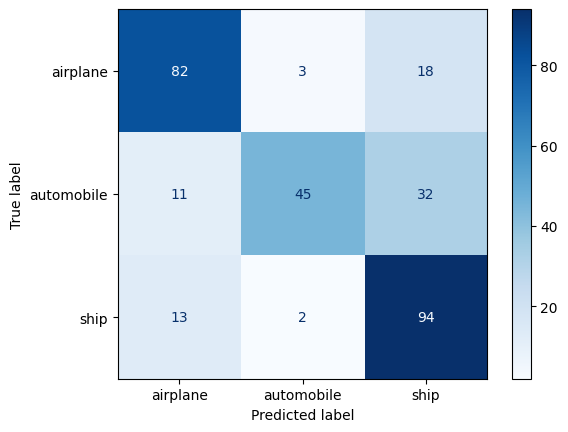

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions and labels for confusion matrix
all_preds = []
all_labels = []

model.eval()  # Ensure the model is in evaluation mode
for data in test_loader:
    images, labels = data
    images = images.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['airplane', 'automobile', 'ship'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


### Early stoping regularization (EXTRA: 1 Point)

~This can only be done if you are able to find a CNN that was able to overfit the train dataset.~

~If that is the case,~ Change the training function in order to perform an [early stopping](https://en.wikipedia.org/wiki/Early_stopping). The early stopping technique using validation is a technique to stop the training process when a defined condition is achieved. Find this condition and change the code.

Discuss the results and why they happened (it works? Why?)


In [ ]:
import torch
import copy

def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience, device):
    best_model_wts = copy.deepcopy(model.state_dict())  # To save the best model weights
    best_loss = float('inf')  # Initialize the best loss to a high value
    early_stop_count = 0  # To track the number of epochs without improvement

    train_losses, val_losses = [], []
    train_bal_accs, val_bal_accs = [], []

    for epoch in range(n_epochs):
        train_loss, train_bal_acc = 0.0, 0.0
        val_loss, val_bal_acc = 0.0, 0.0

        # Training phase
        for data in train_loader:
            loss, balanced_acc = train_batch(model, data, optimizer, criterion, device)
            train_loss += loss
            train_bal_acc += balanced_acc

        # Validation phase
        for data in val_loader:
            loss, balanced_acc = validate_batch(model, data, criterion, device)
            val_loss += loss
            val_bal_acc += balanced_acc

        # Average the metrics over the number of batches
        train_loss /= len(train_loader)
        train_bal_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_bal_acc /= len(val_loader)

        # Store losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_bal_accs.append(train_bal_acc)
        val_bal_accs.append(val_bal_acc)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Balanced Acc: {train_bal_acc:.4f}, Val Loss: {val_loss:.4f}, Val Balanced Acc: {val_bal_acc:.4f}")

        # Early stopping logic: check if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
            early_stop_count = 0  # Reset the counter
        else:
            early_stop_count += 1  # Increment the counter if no improvement

        # Stop early if validation loss does not improve after 'patience' epochs
        if early_stop_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_bal_accs, val_losses, val_bal_accs


In [ ]:
# Criterion
def Criterion(model, preds, targets, device):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    pred_labels = torch.max(preds.data, 1)[1]
    acc = torch.sum(pred_labels == targets.data).item() / targets.size(0)
    return loss, acc


new_model = SimpleCNN(input_shape, n_classes)
new_model.to(device)
new_optimizer = optim.Adam(new_model.parameters(), lr=0.0001)

In [ ]:
# Parameters
n_epochs = 100  # Maximum number of epochs
patience = 5  # Early stopping patience (stop if no improvement for 5 epochs)

# Create DataLoaders
train_loader = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the model with early stopping
best_model, train_losses, train_bal_accs, val_losses, val_bal_accs = train_model_with_early_stopping(
    new_model, train_loader, val_loader, new_optimizer, Criterion, n_epochs, patience, device
)


Epoch [1/100], Train Loss: 1.1301, Train Balanced Acc: 0.4777, Val Loss: 0.9804, Val Balanced Acc: 0.5898
Epoch [2/100], Train Loss: 0.8484, Train Balanced Acc: 0.5759, Val Loss: 1.0072, Val Balanced Acc: 0.4609
Epoch [3/100], Train Loss: 0.8226, Train Balanced Acc: 0.5848, Val Loss: 1.0052, Val Balanced Acc: 0.5117
Epoch [4/100], Train Loss: 0.7625, Train Balanced Acc: 0.6384, Val Loss: 1.1072, Val Balanced Acc: 0.4531
Epoch [5/100], Train Loss: 0.8247, Train Balanced Acc: 0.6429, Val Loss: 0.9899, Val Balanced Acc: 0.5586
Epoch [6/100], Train Loss: 0.6869, Train Balanced Acc: 0.7210, Val Loss: 0.9434, Val Balanced Acc: 0.5742
Epoch [7/100], Train Loss: 0.7050, Train Balanced Acc: 0.6853, Val Loss: 0.9893, Val Balanced Acc: 0.5742
Epoch [8/100], Train Loss: 0.6702, Train Balanced Acc: 0.7165, Val Loss: 0.8745, Val Balanced Acc: 0.6367
Epoch [9/100], Train Loss: 0.6887, Train Balanced Acc: 0.6786, Val Loss: 0.9368, Val Balanced Acc: 0.5859
Epoch [10/100], Train Loss: 0.6869, Train Bala

In [ ]:
save_path = '/content/drive/My Drive/T3_models/bal_acc_early_model_cnn.pth'

# Save the model's state_dict
torch.save(new_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/My Drive/T3_models/bal_acc_early_model_cnn.pth


The early stoppage was able to converge to a moodel which has a very similar bal acc. than the one we got using 100 epochs. So we were able to find a similar model way earlier. However, the early stopping does not return a model that is less overfitted.

## Interpertability on CNNs (1 point)

The Gradient-weighted Class Activation Mapping (Grad-CAM) technique uses the gradient of one or more convolutional layers to highlight the regions of the image that were more impactful to a prediction. For more details, you can read [this paper](https://arxiv.org/abs/1610.02391).

The idea is to use the gradient to create a heatmap indicating the parts that had more weight on the decision for a given sample.

In the next cells, the Grad-CAM code is defined for one layer. You should use this code to test a few images of your best CNN defined in the previous sections. You can change the visualizations if you want.

Analyze the results of Grad-CAM for different images and classes, and discuss whether the model is focusing or not on the right parts of the image and why this may be happening. Feel free to change the code below to visualize in a different way (different quantity of images, different labeling, etc).

-------

**Important: The code below has some assumptions about the network architecture. If the model class is built in a different way you MUST change the implementation of the `get_activations` function.**

In [ ]:
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Truck"
}


def get_activations(model, image, device):
    '''
    Return the activations from the last convolutional layer of the model.
    '''
    # Move the input image to the selected device (GPU or CPU)
    image = image.to(device)

    # Forward pass until the last convolutional layer
    x = model.conv1(image)
    x = model.pool(F.relu(model.bn1(x)))

    x = model.conv2(x)
    x = model.pool(F.relu(model.bn2(x)))

    x = model.conv3(x)
    x = F.relu(model.bn3(x))  # This is the output of the last convolutional layer

    return x  # Return the activations


def get_output_of_the_model(model, image, device):
    '''
    This function is just a "forward" call in "eval" mode, in order to have the predictions for a given image.
    '''
    # Put the model in evaluation mode
    model.eval()

    # Move input tensor (image) to the selected device (GPU or CPU)
    image = image.to(device)

    # Execute the model to get the output predictions
    output = model(image)

    return output

def get_activ(layer, target_layer, activ):
    '''
    This function will recursively search for the layer to be used in Grad-CAM and compute the mean gradient of the output channels.
    '''
    if target_layer == layer:
        grad = layer.weight.grad  # Get the gradient for the layer's weights

        # Multiply activations by the average gradient for each channel
        for i in range(activ.shape[1]):
            activ[:, i, :, :] *= grad[i].mean()

        return activ
    else:
        # Recursively check other layers
        if hasattr(layer, '__getitem__'):  # Check if it's a sequential-like container
            for in_layer in layer:
                activ = get_activ(in_layer, target_layer, activ)
                if activ is not None:
                    return activ

    return None


In [ ]:
def get_heatmap(model, image, target_layer, device):
    '''
    Find a heatmap for a given image and target_layer of the model.
    "device" is the device where the model is running (to use GPU when available)
    '''
    image_in = image.unsqueeze(0)

    # Get the output of the feature extractor (activations from the last conv layer)
    activ  = get_activations(model, image_in, device)

    # Get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, image_in, device)

    # Get the most confident prediction
    pred   = logits.max(-1)[-1]

    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    # If you used the nn.Sequential(), change this line to be "model.sequential.children()"
    for layer in model.children():
        res = get_activ(layer, target_layer, activ)
        if res is not None:
            break

    if res is None:
        raise Exception("Layer not found!")

    heatmap = torch.mean(res, dim=1)[0].cpu().detach()

    heatmap = heatmap.squeeze(0).numpy()
    # Normalize image with minmax
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    # Resize figure to be in the same size as the input image
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

    return heatmap, labels_map[pred.cpu().detach().numpy()[0]]

def display_image_with_heatmap(img, heatmap, scale, ax, true_label, predicted_label):
    '''
    Display the image with the heatmap in a given scale, with labels.
    '''
    heatmap = np.uint8(255.0 * heatmap)
    width   = int(heatmap.shape[1] * scale)
    height  = int(heatmap.shape[0] * scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = 255 * (img - np.min(img)) / (np.max(img) - np.min(img))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255 - heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap * 0.3 + img * 0.7)

    ax.imshow(heatmap)
    ax.set_title(f"True: {true_label} || Predicted: {predicted_label}", {'fontsize': 25})


<ipython-input-21-eb3fa649648d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/T3_models/adam_model_cnn.pth'))


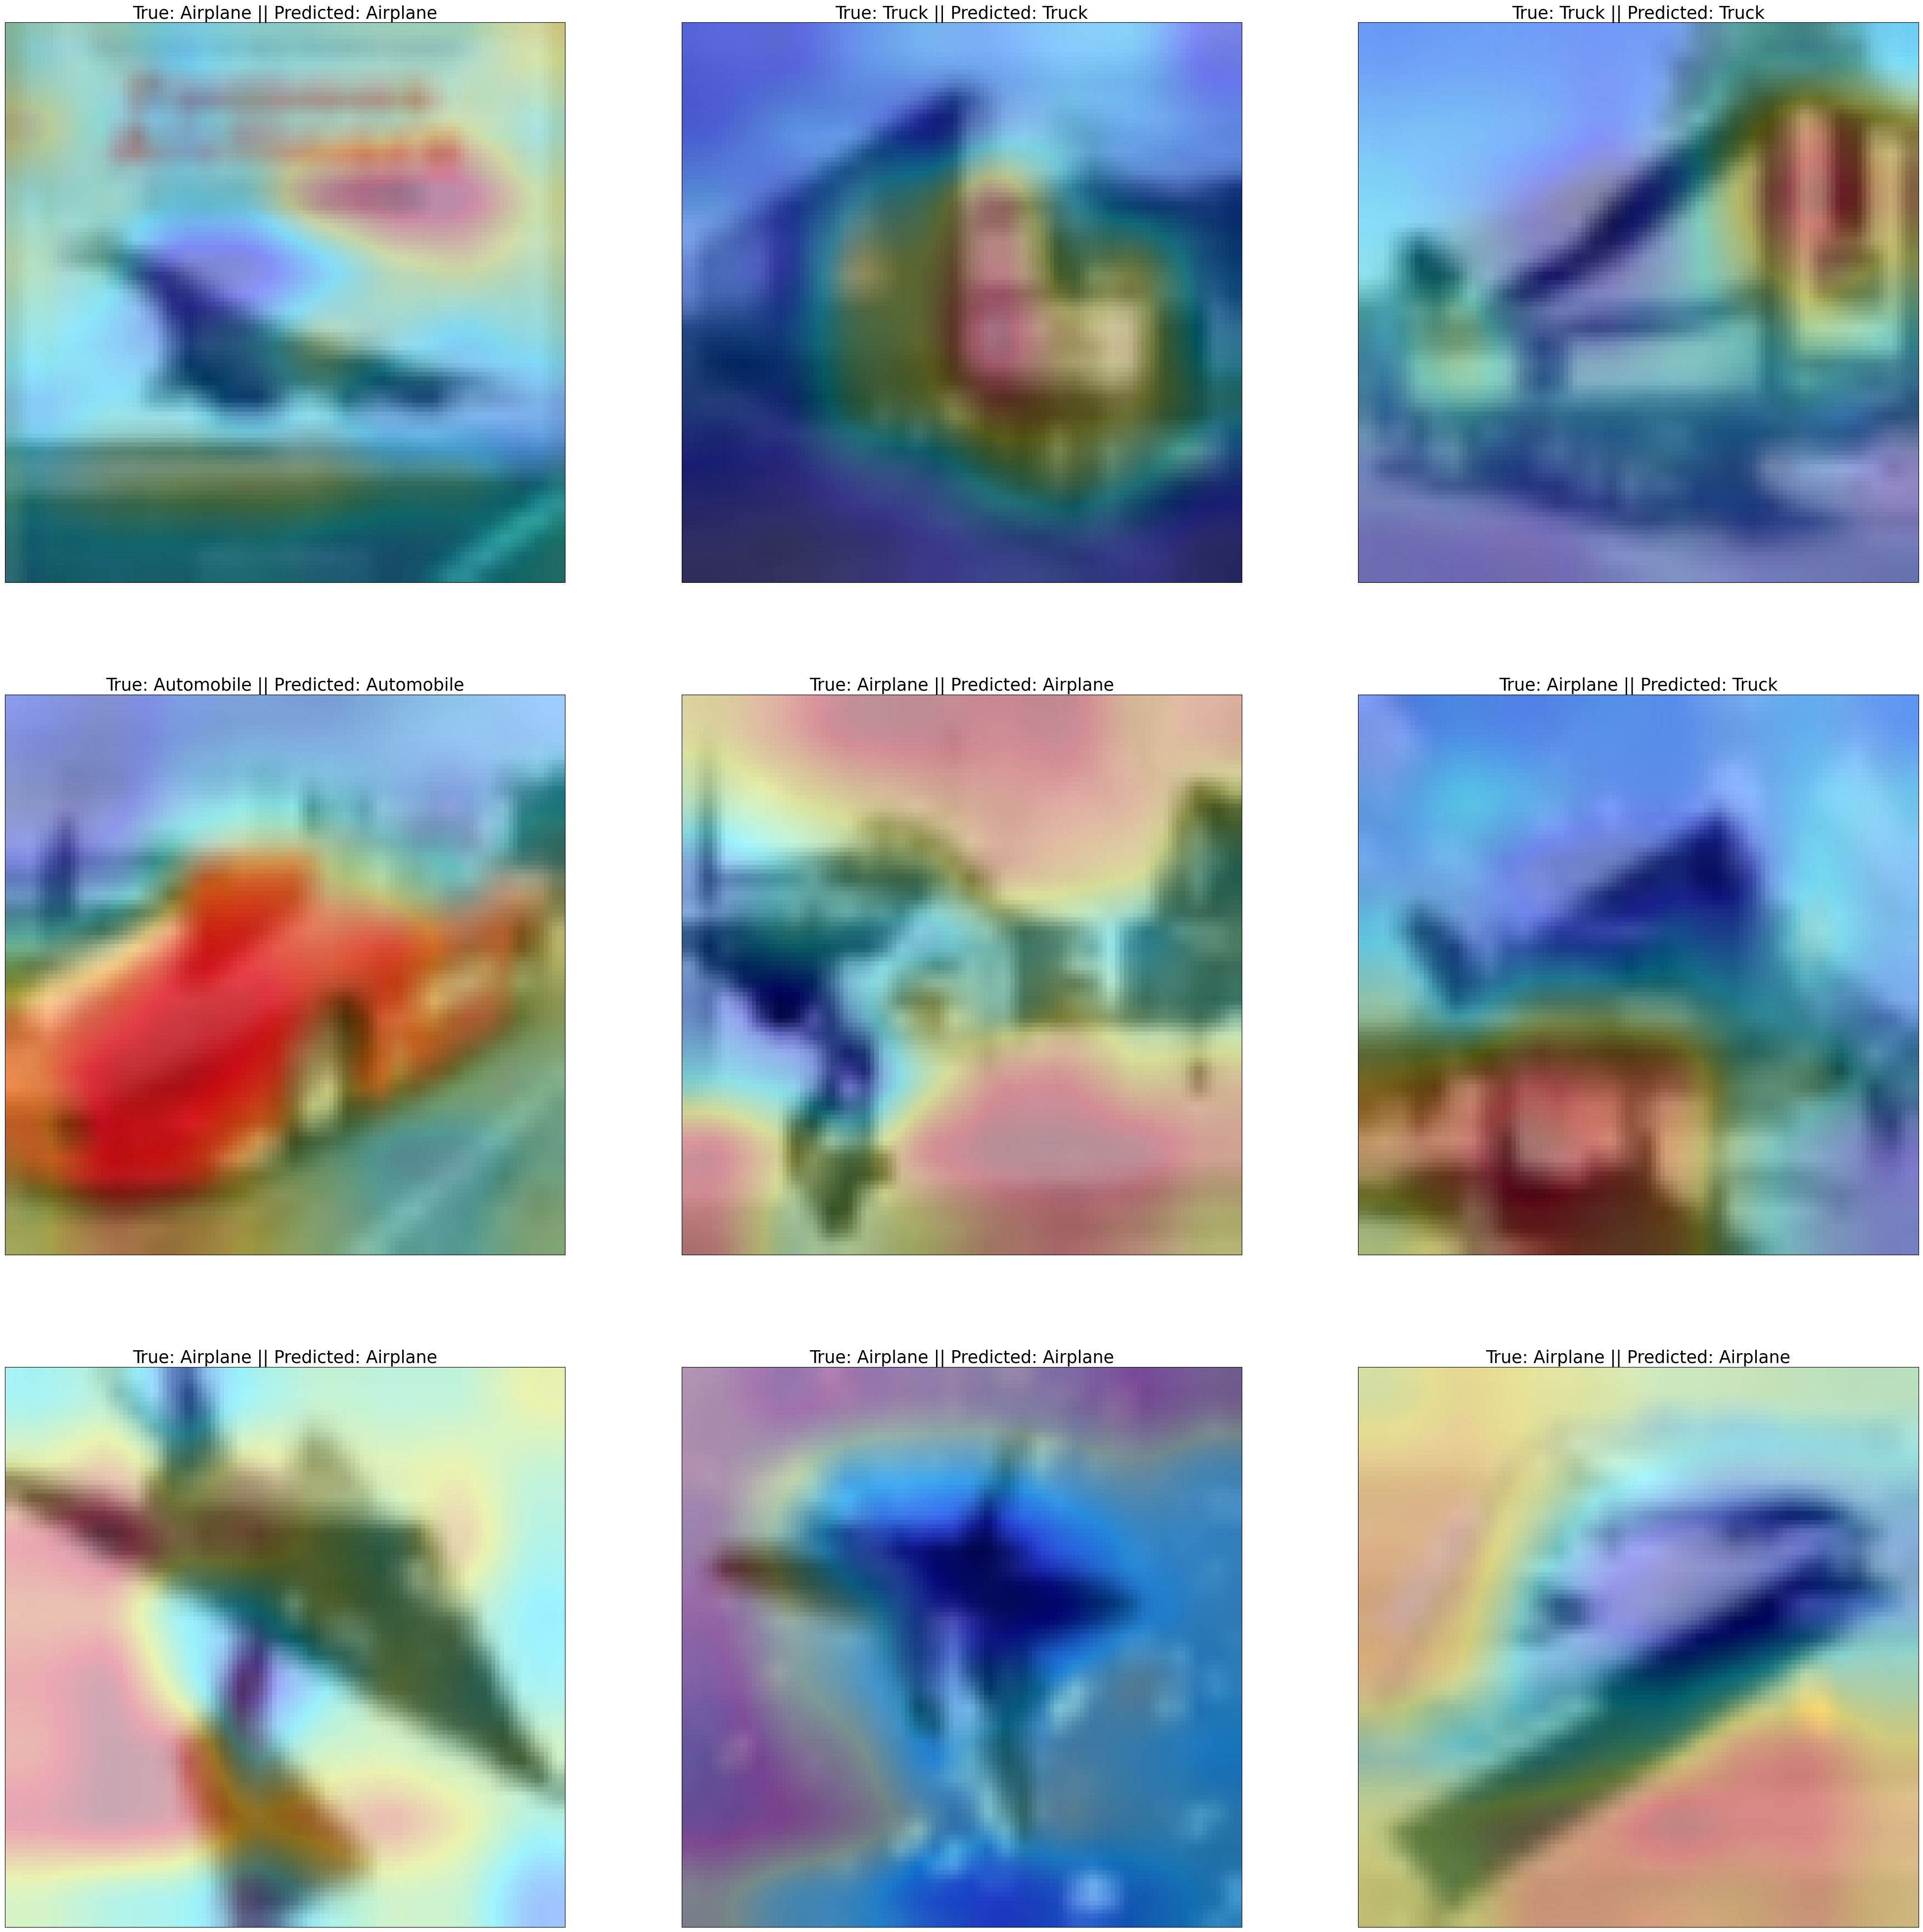

In [ ]:
# Plot multiple images and heatmaps
fig, axes = plt.subplots(3, 3, figsize=(50, 50), subplot_kw={'xticks': [], 'yticks': []})

model = SimpleCNN(input_shape, n_classes)

# let's reload the adam optmized CNN and see how it performs in the test data
model.load_state_dict(torch.load('/content/drive/My Drive/T3_models/adam_model_cnn.pth'))
model.to(device)

for i, ax in enumerate(axes.flat):
    # Load the image and true label from the test dataset
    image, true_label = test_dataset[i * 10]

    # Generate the Grad-CAM heatmap
    heatmap, predicted_label = get_heatmap(model, image, model.conv3, device)  # Adjust 'conv3' to match your model's last conv layer

    # Convert the image back to (Height x Width x Channels)
    image = image.permute(1, 2, 0).numpy()

    # Display the image with the heatmap
    display_image_with_heatmap(image, heatmap, 4, ax, labels_map[true_label], predicted_label)

In [ ]:
# we can notice the the model defined a very good silhouette for the automobile, however for the airplane and truck, we have a much more
# vague silhouette. This may happen due to a imbalance in the classes seen in the training, making the model less efficient in identifying the
# classes that are a minority in our data.

In [ ]:
# We could avoid this balancing the data we have in the trainig, or changing the used metric to adjust the model weights. In this case, since we are
# dealing with a problem in which FP's or FN's are equally to be avoided, a good metric would be the balanced accurancy.

## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.